<a href="https://colab.research.google.com/github/macgyver121/DADS7202_hw2/blob/main/hw2_v3_13_10_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8750d9ea-ff38-6364-6cd3-fa5998eb396d)


In [2]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


## Mount + Import library

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow.keras import activations

## Import + Prepare Data

In [6]:
# Getting names of the classes we have
data_directory = pathlib.Path('/content/drive/MyDrive/hw2_DADS7202_photo_4class')
class_names = [item.name for item in data_directory.glob('*')][0:]
class_names.sort()
print(class_names)

['class1', 'class3', 'class4']


In [7]:
class1_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class1'
class3_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class3'
class4_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class4'
data_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class'

In [8]:
class1_images = len(os.listdir(class1_dir))
class3_images = len(os.listdir(class3_dir))
class4_images = len(os.listdir(class4_dir))

print(f'Number of class1 images: {class1_images}')
print(f'Number of class3 images: {class3_images}')
print(f'Number of class4 images: {class4_images}')

Number of class1 images: 211
Number of class3 images: 200
Number of class4 images: 220


In [9]:
np.random.seed(1234)
tf.random.set_seed(5678)

# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, rescale = 1/255., validation_split = 0.3)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 500,
                                          subset = 'training',
                                          class_mode = 'binary')
test_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 200,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 442 images belonging to 3 classes.
Found 189 images belonging to 3 classes.


## EDA

In [10]:
x_train, y_train = train_data.next()
len(x_train), len(y_train), x_train[0].shape

(442, 442, (224, 224, 3))

In [11]:
x_test, y_test = test_data.next()
len(x_test), len(y_test), x_test[0].shape

(189, 189, (224, 224, 3))

In [12]:
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(442, 224, 224, 3) , min=-0.48501962423324585 , max=0.5923961400985718
x_test: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(189, 224, 224, 3) , min=-0.48501962423324585 , max=0.5923961400985718


In [13]:
df_train = pd.DataFrame(y_train, columns = ['class'])
df_test = pd.DataFrame(y_test, columns = ['class'])

In [14]:
df_train_count = pd.DataFrame(df_train.groupby(['class'])['class'].count())
df_train_count

class
class       
0.0      148
1.0      140
2.0      154

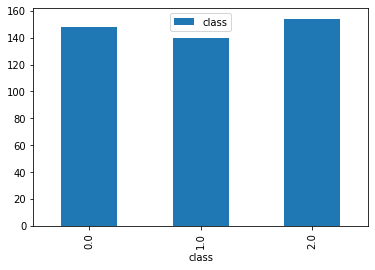

In [15]:
df_train_count.plot.bar()

In [16]:
df_test_count = pd.DataFrame(df_test.groupby(['class'])['class'].count())
df_test_count

class
class       
0.0       63
1.0       60
2.0       66

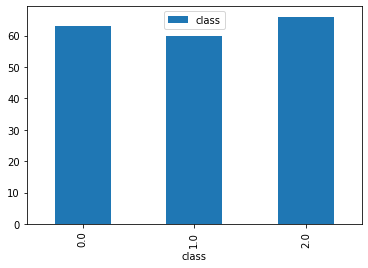

In [17]:
df_test_count.plot.bar()

In [18]:
for i in range(10) :
    print(y_train[i])

2.0
0.0
1.0
0.0
2.0
0.0
0.0
1.0
0.0
0.0


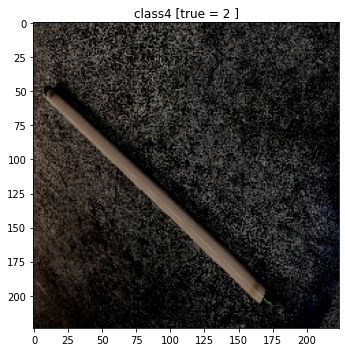

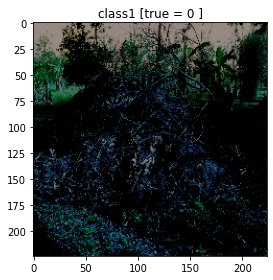

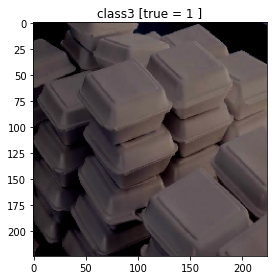

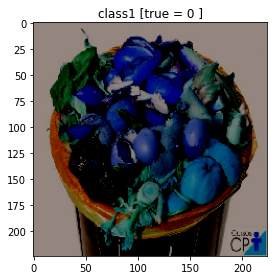

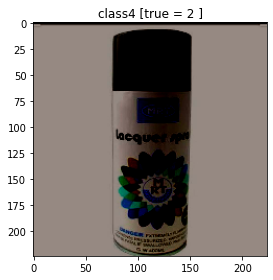

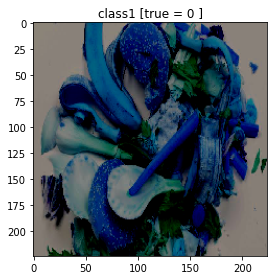

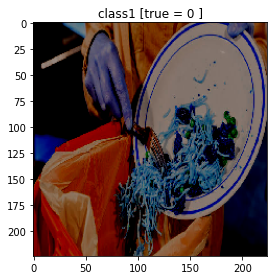

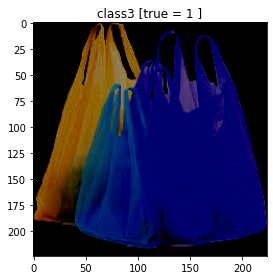

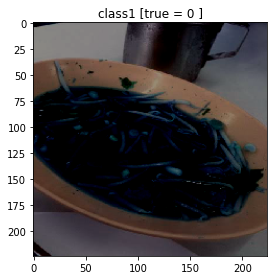

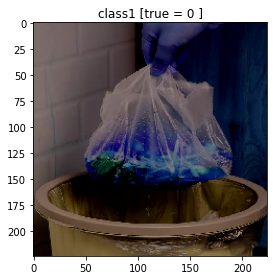

In [19]:
# Visualize the first five images in x_train
plt.figure(figsize=(10,5))
for i in range(0,10):
    plt.title( f"{class_names[ int(y_train[i]) ]} [true = {int(y_train[i])} ]") 
    plt.imshow( x_train[i] )  
    plt.tight_layout()       
    plt.show()

# Use original model

## Prepare pretained Model (Original)

In [20]:
# Load the ImageNet VGG-16 model, including both the feature extractor part and the classifier part
# By default, VGG-16 is designed for an input image of dimension 224x224x3
vgg = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=True)

vgg.summary()

553467096/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [21]:
from keras.models import Model

vgg_extractor= Model(inputs=vgg.input, outputs=vgg.layers[-2].output)
vgg_extractor.summary()

for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
vgg_extractor.trainable = False

for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False
Layer 19: name = flatten , trainable = False
Layer 20: name = fc1 , tr

In [23]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model 

new_outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Train the Model (Original)

In [24]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

In [25]:
np.random.seed(1234)
tf.random.set_seed(5678)

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 20, 
                                        restore_best_weights = True)

history = model.fit( x_train , y_train, batch_size=5, epochs=10, verbose=1, validation_split=0.3, callbacks=[earlystopping] )

Epoch 1/10
62/62 [==============================] - 14s 101ms/step - loss: 0.9504 - acc: 0.5599 - val_loss: 0.9184 - val_acc: 0.6767
Epoch 2/10
62/62 [==============================] - 4s 58ms/step - loss: 0.4315 - acc: 0.8350 - val_loss: 0.4686 - val_acc: 0.7594
Epoch 3/10
62/62 [==============================] - 4s 63ms/step - loss: 0.4112 - acc: 0.8220 - val_loss: 0.4181 - val_acc: 0.7744
Epoch 4/10
62/62 [==============================] - 4s 58ms/step - loss: 0.3817 - acc: 0.8220 - val_loss: 0.3459 - val_acc: 0.8045
Epoch 5/10
62/62 [==============================] - 4s 58ms/step - loss: 0.3748 - acc: 0.8414 - val_loss: 0.3155 - val_acc: 0.8722
Epoch 6/10
62/62 [==============================] - 3s 54ms/step - loss: 0.2746 - acc: 0.9029 - val_loss: 0.4183 - val_acc: 0.8195
Epoch 7/10
62/62 [==============================] - 3s 54ms/step - loss: 0.2679 - acc: 0.8932 - val_loss: 0.3181 - val_acc: 0.8872
Epoch 8/10
62/62 [==============================] - 4s 59ms/step - loss: 0.1925 -

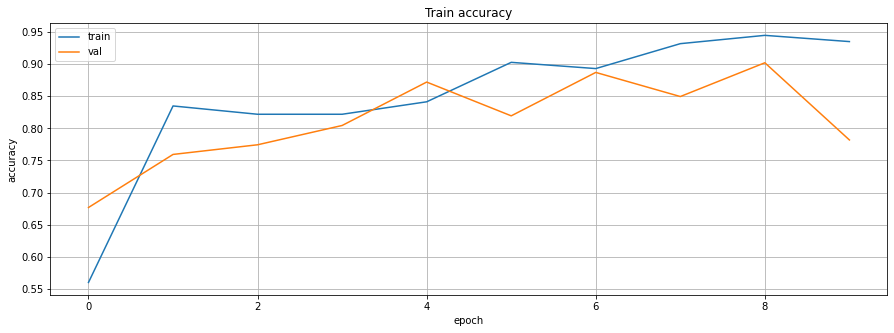

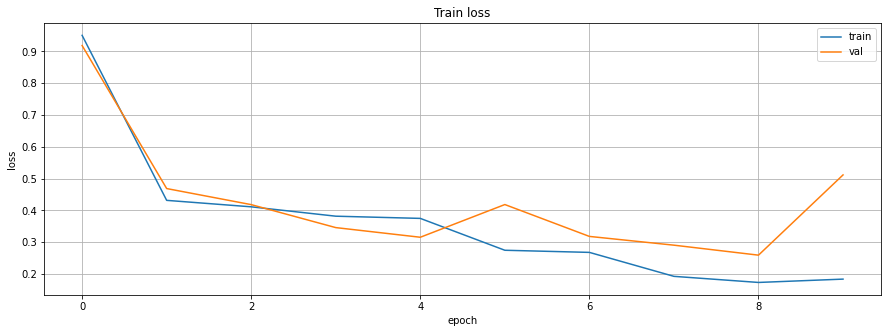

In [26]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

## Evaluate on test set (Original)

In [28]:
# Evaluate the trained model on the test set
results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

6/6 [==============================] - 1s 151ms/step - loss: 0.9386 - acc: 0.7037
['loss', 'acc']: [0.9385595321655273, 0.7037037014961243]


# Use tuning model VGG16

## Prepare pretrained Model (Tuning)

In [29]:
# Load the ImageNet VGG-16 model, including both the feature extractor part and the classifier part
# By default, VGG-16 is designed for an input image of dimension 224x224x3
img_w,img_h = 224,224 
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))

vgg_extractor.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

### freeze model

In [30]:
vgg_extractor.trainable = False

for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_2 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False


### add classifier

In [31]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Train the model with transfer learning (Tuning)

In [32]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

In [35]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 20, 
                                        restore_best_weights = True)

history = model.fit( x_train, y_train, batch_size=5, epochs=10, verbose=1, validation_split=0.3, callbacks=[earlystopping])

Epoch 1/10
62/62 [==============================] - 4s 60ms/step - loss: 0.2039 - acc: 0.9320 - val_loss: 0.5507 - val_acc: 0.9173
Epoch 2/10
62/62 [==============================] - 3s 56ms/step - loss: 0.0941 - acc: 0.9806 - val_loss: 1.0325 - val_acc: 0.8346
Epoch 3/10
62/62 [==============================] - 3s 57ms/step - loss: 0.1483 - acc: 0.9741 - val_loss: 0.6602 - val_acc: 0.8797
Epoch 4/10
62/62 [==============================] - 4s 58ms/step - loss: 0.0807 - acc: 0.9838 - val_loss: 0.2720 - val_acc: 0.9323
Epoch 5/10
62/62 [==============================] - 3s 57ms/step - loss: 0.0452 - acc: 0.9838 - val_loss: 0.2990 - val_acc: 0.9474
Epoch 6/10
62/62 [==============================] - 3s 57ms/step - loss: 0.0112 - acc: 0.9935 - val_loss: 0.3963 - val_acc: 0.9098
Epoch 7/10
62/62 [==============================] - 4s 58ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.2130 - val_acc: 0.9323
Epoch 8/10
62/62 [==============================] - 3s 56ms/step - loss: 0.0144 - a

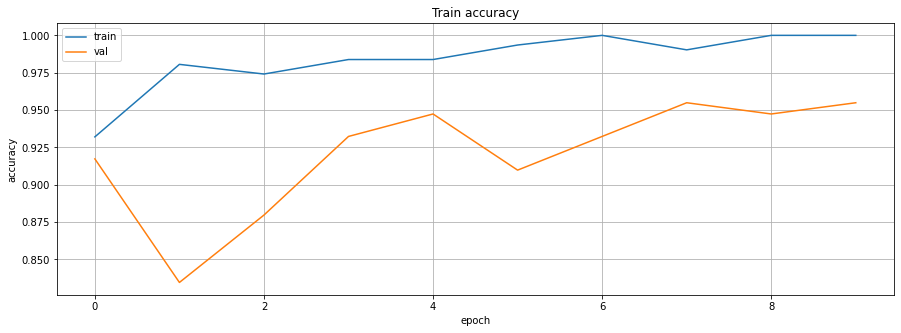

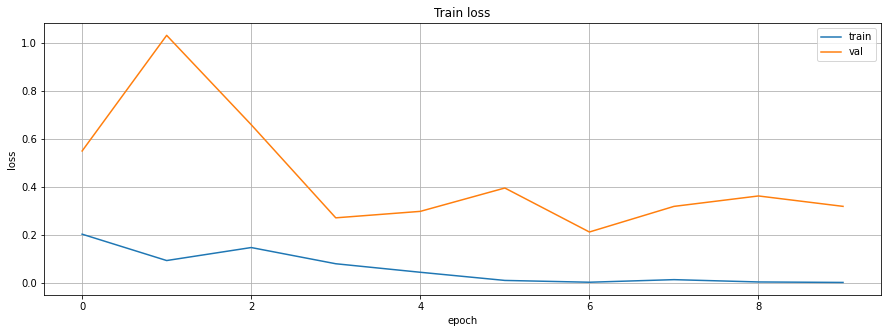

In [36]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

## Evaluate the model on test set (Tuning)

In [37]:
# Evaluate the trained model on the test set
results = model.evaluate(x_test, y_test, batch_size=24)
print( f"{model.metrics_names}: {results}" )

8/8 [==============================] - 5s 417ms/step - loss: 1.3155 - acc: 0.8360
['loss', 'acc']: [1.315453290939331, 0.8359788656234741]


## Inference

In [38]:
y_pred = model.predict(x_test)
print(y_pred.shape)

6/6 [==============================] - 1s 155ms/step
(189, 3)


In [39]:
lst = []
for i in y_pred :
    lst.append(np.argmax(i))

type(np.array(lst))

numpy.ndarray

In [40]:
y_test[0:10]

array([0., 2., 2., 2., 0., 1., 1., 1., 0., 0.], dtype=float32)

In [41]:
lst[0:10]

[0, 2, 2, 2, 0, 0, 1, 1, 0, 0]

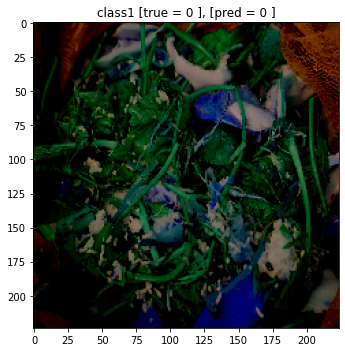

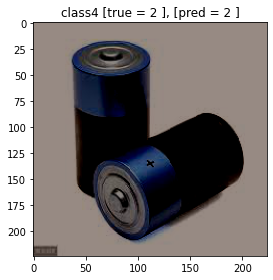

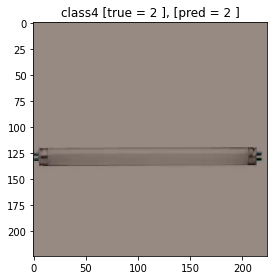

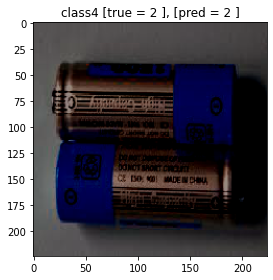

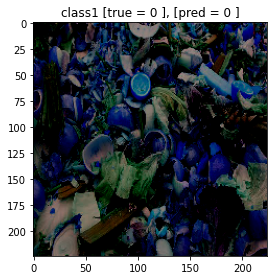

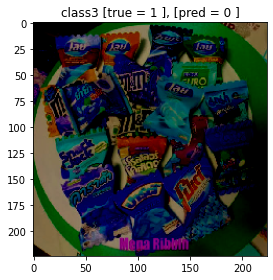

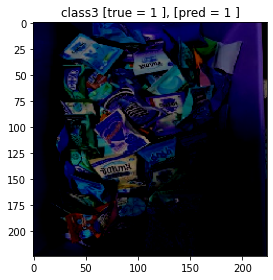

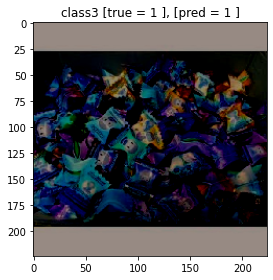

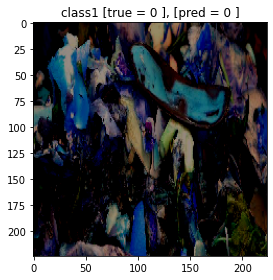

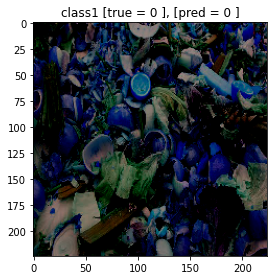

In [42]:
# Visualize the first five images in test
plt.figure(figsize=(10,5))
for i in range(0,10):
    plt.title( f"{class_names[ int(y_test[i]) ]} [true = {int(y_test[i])} ], [pred = {lst[i]} ]") 
    plt.imshow( x_test[i] )  
    plt.tight_layout()       
    plt.show()

## Check error

In [43]:
y_test = y_test.astype(int)
df = pd.DataFrame(list(zip(y_test, lst)), columns = ['y_test', 'y_pred'])

In [44]:
print(df.head())

   y_test  y_pred
0       0       0
1       2       2
2       2       2
3       2       2
4       0       0


In [45]:
index_list = df[df['y_test'] != df['y_pred']].index

In [46]:
index_list

Int64Index([  5,  12,  13,  16,  25,  26,  29,  32,  43,  52,  61,  62,  88,
             89,  97, 100, 109, 115, 116, 121, 124, 127, 130, 140, 151, 155,
            157, 171, 174, 179, 182],
           dtype='int64')

In [50]:
len(index_list)

31

In [47]:
df.iloc[index_list]

y_test  y_pred
5         1       0
12        2       0
13        2       1
16        1       0
25        2       1
26        0       1
29        0       1
32        1       0
43        1       0
52        2       1
61        2       1
62        1       0
88        2       1
89        1       0
97        2       1
100       2       1
109       1       2
115       2       1
116       1       2
121       0       1
124       1       0
127       1       0
130       1       2
140       2       1
151       1       0
155       1       0
157       2       0
171       1       0
174       1       0
179       2       1
182       1       0

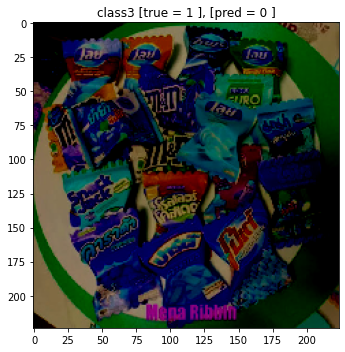

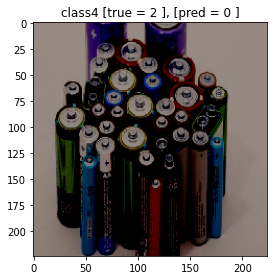

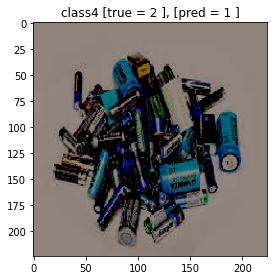

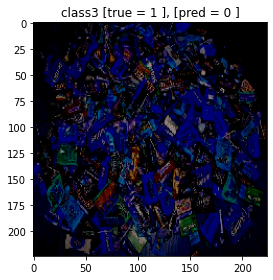

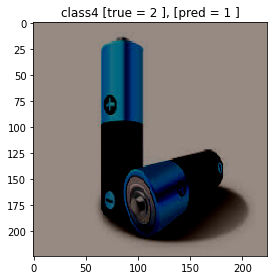

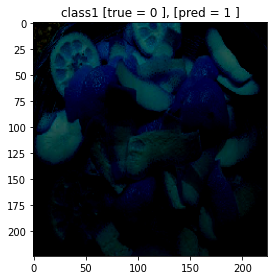

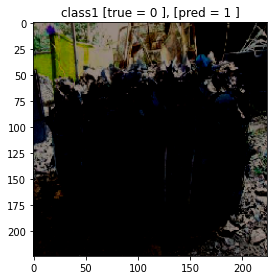

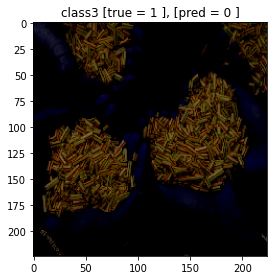

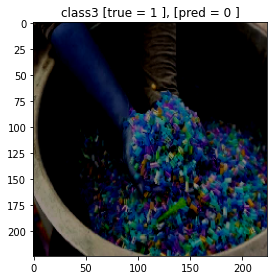

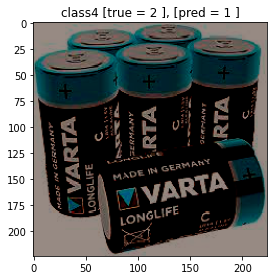

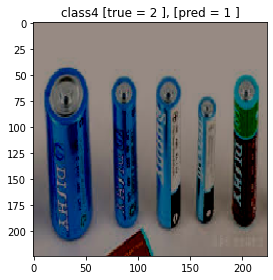

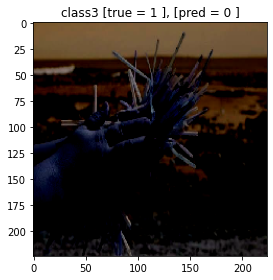

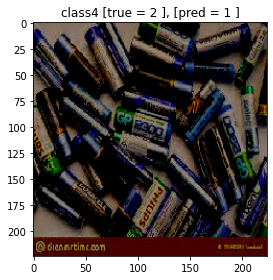

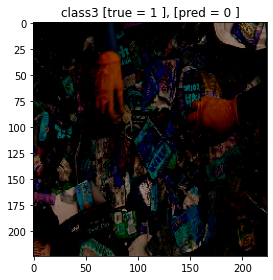

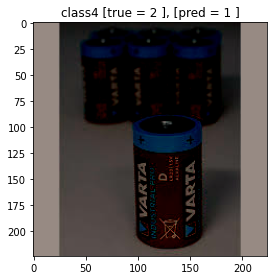

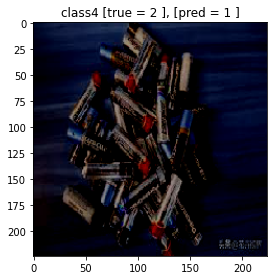

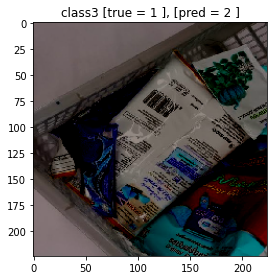

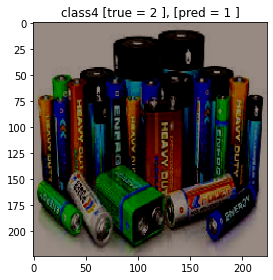

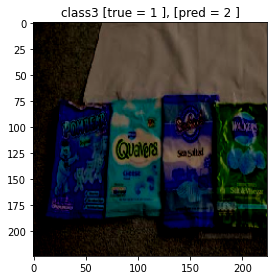

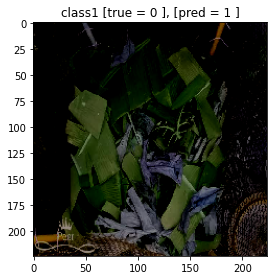

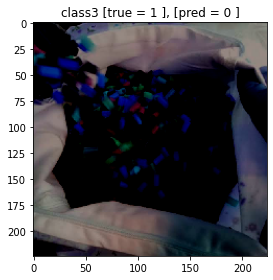

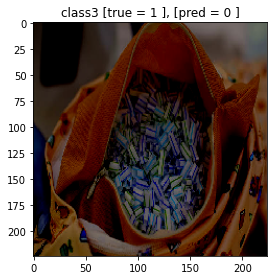

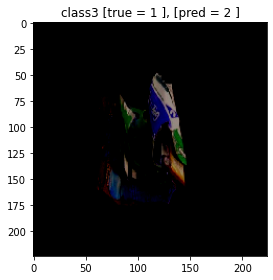

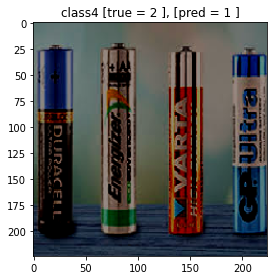

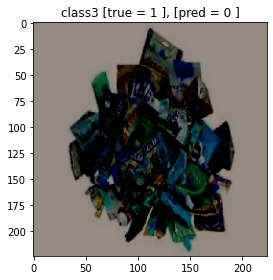

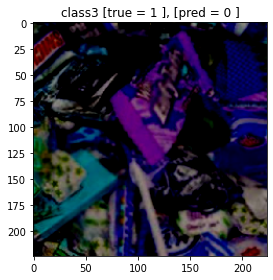

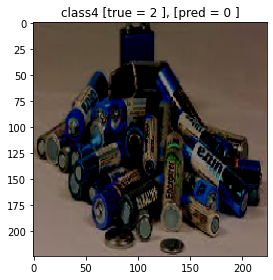

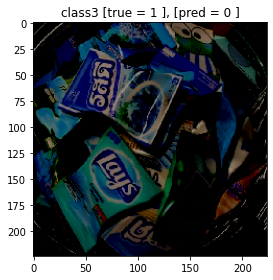

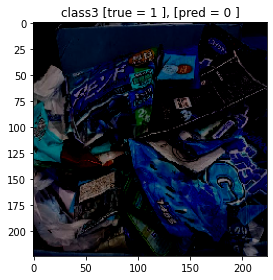

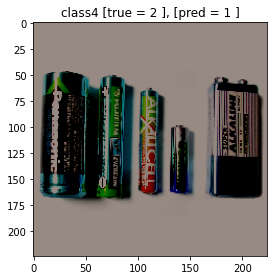

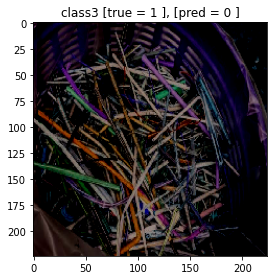

In [48]:
# Visualize the first five images in test
plt.figure(figsize=(10,5))
for i in index_list:
    plt.title( f"{class_names[ int(y_test[i]) ]} [true = {int(y_test[i])} ], [pred = {lst[i]} ]") 
    plt.imshow( x_test[i] )  
    plt.tight_layout()       
    plt.show()

# Use Grad-CAM for CNN visualization

## Create base model

In [ ]:
base_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[-2].output)
base_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
x = base_model.output
new_outputs = tf.keras.layers.Dense(3, activation=None)(x)

# Construct the main model 
base_model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
base_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
print( base_model.layers[-1].activation )

<function linear at 0x7feeb569ab90>


## Adapt base model

In [ ]:
def alter_model_for_GradCAM( model, last_conv_layer_name ):
    # 1. Get the output from the last convolutional layer
    last_conv_output = model.get_layer( last_conv_layer_name ).output

    # 2. Create the new model with one additional output
    # -  Suppose that the 'model' here outputs raw (logit, non-softmax) outputs
    new_model = tf.keras.Model( inputs=model.inputs, outputs=[model.output, last_conv_output] )
    
    return new_model

new_model = alter_model_for_GradCAM( base_model, 'block5_pool' )
new_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  